<a href="https://colab.research.google.com/github/federicodeluca/question_classification_bert/blob/main/BERT_for_question_classification_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INTRODUCTION
This Colab notebook is a revised and extended version of the original project discussed in class, which can be found here: https://colab.research.google.com/drive/1XcMbSJOaMTV6CQeh9UQq-vY1ZNb1iweg?usp=sharing.

The original notebook already includes explanations for the key functions, along with some useful reference links.

In this version, I have restructured the code to create a more modular and reusable pipeline. The goal is to make it easier to solve similar exercises using different models with minimal adjustments. This modular approach improves readability, flexibility, and maintainability of the code.

**Important note:** To efficiently run this notebook, I used Colab's A100 High-RAM GPU upgrade (€11/month). Execution time may increase significantly if using a standard GPU or CPU environment.

# Tranining a sentence classifier using BERT-based models
In this notebook, I will explore the usage of different BERT models. The notebook is divided into two parts:




* Part 1: Using various BERT models and hyperparameters to solve a sentence
classification task, specifically the Question Classification task.
Given a natural language question, the classifier assigns it to a class reflecting its intent. For example, "Who is Galileo?" refers to the class PERSON, while "Where is Rome?" refers to LOCATION.
We will use the Question Classification dataset (in English), where questions are categorized into 6 coarse-grained classes.

* Part 2 (Exercise 2): Building a classifier based on a BERT model for the 20 Newsgroups Text Classification task. The model will be trained and evaluated with the goal of exceeding a baseline accuracy of 74%.
The 20 Newsgroups dataset contains approximately 20,000 newsgroup documents distributed across 20 different categories. It is widely used for text classification and clustering tasks. Each category represents a distinct topic, such as politics, sports, religion, or science.

# **PART 1**: Question Classification Dataset

This part is about the Question Classification Dataset. The explanation of the functions can be found in the original notebook

#**STEP 0**: Setup Environment and Imports

In [ ]:
import torch
import io
import torch.nn.functional as F
import random
import numpy as np
import time
import math
import datetime
import torch.nn as nn
from transformers import *
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt

##Set random values
seed_val = 213
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed_val)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: '__init_subclass__' (from 'transformers.agents.tools') is deprecated and will be removed from version '4.51.0'. Switch to smolagents instead, with the same functionalities and similar API (https://huggingface.co/docs/smolagents/index)
  warnings.warn(warning_message, FutureWarning)
GroupViT models are not usable since `tensorflow_probability` can't be loaded. It seems you have `tensorflow_probability` installed with the wrong tensorflow version.Please try to reinstall it following the instructions here: https://github.com/tensorflow/probability.
TAPAS models are not usable since `tensorflow_probability` can't be loaded. It seems you have `tensorflow_probability` installed with the wrong tensorflow version. Please try to reinstall it following the instructions here: https://github.com/tensorflow/probability.


In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using the MPS device for MAC")
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA A100-SXM4-40GB


In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

# **STEP 1**: Loading dataset
Given a question in natural language, a classifier associates it to a class reflecting the aim. E.g., "*Who is Galileo?*" refers to a `PERSON` while "*Where is Rome?*" refers to a `LOCATION`.

We will use the **Question Classification** dataset (in English),
where questions are associated to 6 classes at coarse-grained level of granularity.

In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path_train = 'drive/MyDrive/question_classification_cleaned_fedbor.csv'
file_path_test = 'drive/MyDrive/test.csv'


df_train = pd.read_csv(file_path_train)
df_test = pd.read_csv(file_path_test)

train_sentences = df_train['questions'].to_list() #list for train question and labels
train_labels = df_train['classes'].to_list()



test_sentences = df_test['questions'].to_list()
test_labels = df_test['classes'].to_list()



train_examples = list(zip(train_sentences, train_labels))
test_examples = list(zip(test_sentences, test_labels))

In [ ]:
# This is a multi-class classification task.
label_list = list(set(train_labels) | set(test_labels))

label_list.sort()
# Let us print the labels used in the dataset
print("Target Labels:\t" + str(label_list))
print("Number of Labels:\t" + str(len(label_list)))

Target Labels:	['ABBR', 'DESC', 'ENTY', 'HUM', 'LOC', 'NUM']
Number of Labels:	6


#  **STEP 2:** Select an Encoder
This step is crucial. We will select different BERT-based encoders to evaluate and compare their performance. The goal is to identify the best BERT encoder for our task. Therefore, this part will later be extended into a loop to automate training and evaluation across multiple models.

# **STEP 3:** Define the Pytorch classifier

This class defines a simple neural network classifier built on top of a BERT-like transformer model. The classifier is designed to take advantage of the [CLS] token's embedding,produced by the final hidden layer of the transformer, to perform classification tasks.

The model is initialized with a pretrained encoder (e.g., BERT, RoBERTa, etc.), whose hidden size is automatically retrieved using AutoConfig. A dropout layer is applied to the [CLS] representation to reduce overfitting, followed by a linear layer that maps the representation to the desired number of output classes.

This modular design allows easy switching between different pretrained models by simply changing the model_name.

The forward method defines how the input data flows through the model: it encodes the input using the transformer, extracts the [CLS] token embedding, applies dropout, and then performs classification using a fully connected layer.

In [ ]:
class Classifier(nn.Module):
    def __init__(self, model_name, num_labels=2, dropout_rate=0.1):
      super(Classifier, self).__init__()
      # Load the BERT-based encoder
      self.encoder = AutoModel.from_pretrained(model_name) #auto model with the model name
      # The AutoConfig allows to access the encoder configuration.
      # The configuration is needed to derive the size of the embedding, which
      # is produced by BERT (and similar models) to encode the input elements.
      config = AutoConfig.from_pretrained(model_name) #how many tokens the model can handle, or what is the size of the vector that rappresent a word
      #and dont need to define this configuration you just write the 1 line code
      self.cls_size = int(config.hidden_size) #size of cls token (the blue vector)
      # Dropout is applied before the final classifier
      self.input_dropout = nn.Dropout(p=dropout_rate)
      # Final linear classifier
      self.fully_connected_layer = nn.Linear(self.cls_size,num_labels) #a MLP in over the CLS vector at the end MLP which in the input as the size of CLS vector
      #and the output the number of class (6)
      #first encoding then you pick up the vector of CLS and use this vector in MLP.
    def forward(self, input_ids, attention_mask): #define how data go trhough the classifier the forward pass
    #we have to use these encoder method which is
      # encode all outputs
      model_outputs = self.encoder(input_ids, attention_mask, output_hidden_states=True) #this encoder take the text map the vector to id_ set the attention mask
      #attention mechanism over the sentences (token max 512).
      # just select the vector associated to the [CLS] symbol used as
      # first token for ALL sentences
      last_hidden_states = model_outputs.hidden_states[-1] #this is the several vectors that the BERT model output using this yuo have several vector
      #rappresentation of our words and our texts
      #picking vector of CLS we are picking information of all the text.


      # the shape of last_hidden_states will be [batch_size, tokens, hidden_dim] so
      # if you want to get the embedding of the first element in the batch
      # and the [CLS] token you can get it with last_hidden_states[0,0,:].
      encoded_cls = last_hidden_states[:,0,:]
      # apply dropout
      encoded_cls_dp = self.input_dropout(encoded_cls)
      # apply the linear classifier
      logits = self.fully_connected_layer(encoded_cls_dp)
      # return the logits
      return logits, encoded_cls

## STEP 3.1 : Model Configuration and Hyperparameters
default_config is a dictionary that contains all the configuration parameters for the model and training (batch size, learning rate, number of epochs, etc.).

In [ ]:
default_config = {
    "max_seq_length": 64,
    "out_dropout_rate": 0.1,
    "dev_perc": 0.1,
    "batch_size": 64,
    "learning_rate": 2e-5,
    "num_train_epochs": 5,
    "output_model_name": "best_model_distilbert_base_cased.pt",
    "apply_scheduler": False,
    "warmup_proportion": 0.1,
    "print_each_n_step": 10

}


# **STEP 4:** Tokenization and Input Length Visualization

In order to customize one parameter, i.e., the maximum size of input sequences, we need to process the datasets.

**IMPORTANT** input sequences are expected to be tokenized in order to be used in input to a BERT-based model. This requires a `tokenizer` which converts each input sentence into a sequence of word-pieces, each associated to input vectors, which can be used as input in the encoder. Each model is associated to a `tokenizer` and this is acquired before the initial training process.

We define a function to initialize the tokenizer for any given model. This function loads the appropriate tokenizer using the model name and, optionally, plots the distribution of input lengths in the training set. This can help in understanding how much padding or truncation might be needed.

In [ ]:
# Define a Tokenizer
#parameters of our model

def setup_tokenizer_and_show_lengths(model_name, train_examples, show_plot=False):
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    if show_plot:
        plt.style.use("ggplot")
        lengths = [len(tokenizer.encode_plus(text)["input_ids"]) for (text, label) in train_examples]
        plt.hist(lengths, bins=20)
        plt.title(f"Input Length Distribution for {model_name}")
        plt.xlabel("Tokenized Length")
        plt.ylabel("Frequency")
        plt.show()

    return tokenizer

# **STEP 5**: Build model components

This function initializes and returns the main components needed for training: the classifier, the optimizer, and optionally a learning rate scheduler.

It takes the following arguments:



1.   model_name: the name of the pretrained model to use.
2.   num_labels: the number of output classes for classification.
3. dropout_rate: the dropout probability applied before the final layer.
4. learning_rate: the learning rate for the optimizer.
5. config: a dictionary containing additional training settings, such as batch size, number of training examples, number of epochs, and whether to apply a learning rate scheduler.

In [ ]:
def build_model_components(model_name, num_labels, dropout_rate, learning_rate, config):
    """
    Build and return the classifier, optimizer, and optional scheduler,
    using the provided tokenizer (already initialized).
    """
    classifier = Classifier(model_name, num_labels=num_labels, dropout_rate=dropout_rate)
    classifier.to(device)

    optimizer = torch.optim.AdamW(classifier.parameters(), lr=learning_rate)

    scheduler = None
    if config["apply_scheduler"]:
        num_train_examples = config["num_train_examples"]
        num_train_steps = int(num_train_examples / config["batch_size"] * config["num_train_epochs"])
        num_warmup_steps = int(num_train_steps * config["warmup_proportion"])
        scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps)

    return classifier, optimizer, scheduler


# **STEP 6**: Convert data into Dataloader(s)

The following method is used to convert input material into `DataLoader` that will be used to handle examples (during the training and the evaluation phase). Dataloaders are used in PyTorch to handle data, to split it into batches and to shuffle data.

This function creates two dictionaries to map between label names and their corresponding numeric IDs. (Pyhton works with numbers!)

In [ ]:
def create_label_maps(label_list):
    label_to_id = {label: i for i, label in enumerate(label_list)}
    id_to_label = {i: label for i, label in enumerate(label_list)}
    return label_to_id, id_to_label

This function splits a dataset into training and development (validation) sets.

In [ ]:
def split_train_dev(examples, dev_perc, seed=213):
    random.seed(seed)
    random.shuffle(examples)
    split_idx = int(len(examples) * (1 - dev_perc))
    return examples[:split_idx], examples[split_idx:]

In [ ]:
def generate_data_loader(examples, label_map, tokenizer, batch_size, max_seq_length, do_shuffle=False):
    input_ids = []
    input_mask_array = []
    label_id_array = []

    for (text, label) in examples:
        encoded_sent = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_seq_length,
            padding='max_length',
            truncation=True
        )
        input_ids.append(encoded_sent['input_ids'])
        input_mask_array.append(encoded_sent['attention_mask'])

        id = label_map.get(label, -1)
        label_id_array.append(id)

    input_ids = torch.tensor(input_ids)
    input_mask_array = torch.tensor(input_mask_array)
    label_id_array = torch.tensor(label_id_array, dtype=torch.long)

    dataset = TensorDataset(input_ids, input_mask_array, label_id_array)
    sampler = RandomSampler(dataset) if do_shuffle else SequentialSampler(dataset)

    return DataLoader(dataset, sampler=sampler, batch_size=batch_size)

# **STEP 7**: Evaluation and Metrics

This function evaluates the performance of a trained classifier on a given dataset, computing both the average loss and accuracy (also the confusion matrix)

In [ ]:
def evaluate(dataloader, classifier, tokenizer, id_to_label_map, label_list, nll_loss_fn, print_classification_output=False, print_result_summary=False):
    total_loss = 0
    gold_classes = []
    system_classes = []

    if print_classification_output:
        print("\n------------------------")
        print("  Classification outcomes")
        print("is_correct\tgold_label\tsystem_label\ttext")
        print("------------------------")

    for batch in dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            logits, _ = classifier(b_input_ids, b_input_mask)
            total_loss += nll_loss_fn(logits, b_labels)

        _, preds = torch.max(logits, 1)
        system_classes += preds.detach().cpu()
        gold_classes += b_labels.detach().cpu()

        if print_classification_output:
            for ex_id in range(len(b_input_mask)):
                input_strings = tokenizer.decode(b_input_ids[ex_id], skip_special_tokens=True)
                predicted_label = id_to_label_map.get(preds[ex_id].item(), "UNK")
                gold_standard_label = id_to_label_map.get(b_labels[ex_id].item(), "UNK")
                output = '[OK]' if predicted_label == gold_standard_label else '[NO]'
                print(f"{output}\t{gold_standard_label}\t{predicted_label}\t{input_strings}")

    avg_loss = total_loss / len(dataloader)
    avg_loss = avg_loss.item()

    system_classes = torch.stack(system_classes).numpy()
    gold_classes = torch.stack(gold_classes).numpy()
    accuracy = np.sum(system_classes == gold_classes) / len(system_classes)

    if print_result_summary:
        print("\n------------------------")
        print("  Summary")
        print("------------------------")
        filtered_label_list = [id_to_label_map[i] for i in sorted(set(gold_classes))]
        print(classification_report(gold_classes, system_classes, digits=3, target_names=filtered_label_list))

        print("\n------------------------")
        print("  Confusion Matrix")
        print("------------------------")
        conf_mat = confusion_matrix(gold_classes, system_classes)
        for row_id in range(len(conf_mat)):
            print(f"{filtered_label_list[row_id]}\t{conf_mat[row_id]}")

    return avg_loss, accuracy

# **STEP 8**: Training and Validation

This function manages the full training loop for the classifier model, including evaluation on a development set at the end of each epoch. It tracks performance over time and saves the best-performing model based on validation accuracy.

After each epoch:
- Evaluates the model on the validation set using the evaluate() function.

- Logs key training statistics (loss, accuracy, duration).

- Saves the model if it achieves a new best validation accuracy.

In [ ]:
def train_and_validate(classifier, train_dataloader, dev_dataloader, optimizer, scheduler, nll_loss_fn, config, output_model_name):
    training_stats = []
    best_dev_accuracy = -1
    total_t0 = time.time()

    for epoch_i in range(config["num_train_epochs"]):
        print(f"\n======== Epoch {epoch_i + 1} / {config['num_train_epochs']} ========")
        print("Training...")

        t0 = time.time()
        train_loss = 0
        classifier.train()

        for step, batch in enumerate(train_dataloader):
            if step % config["print_each_n_step"] == 0 and step > 0:
                elapsed = format_time(time.time() - t0)
                print(f'  Batch {step:>5}  of  {len(train_dataloader):>5}.    Elapsed: {elapsed}')

            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            optimizer.zero_grad()
            logits, _ = classifier(b_input_ids, b_input_mask)
            loss = nll_loss_fn(logits, b_labels)
            loss.backward()
            optimizer.step()

            if scheduler is not None:
                scheduler.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_dataloader)
        training_time = format_time(time.time() - t0)
        print(f"\n  Average training loss: {avg_train_loss:.3f}")
        print(f"  Training epoch took: {training_time}")

        # Validation
        print("\nRunning Dev Evaluation...")
        t0 = time.time()
        classifier.eval()
        avg_dev_loss, dev_accuracy = evaluate(
            dataloader=dev_dataloader,
            classifier=classifier,
            tokenizer=config["tokenizer"],
            id_to_label_map=config["id_to_label_map"],
            label_list=config["label_list"],
            nll_loss_fn=nll_loss_fn
        )
        dev_time = format_time(time.time() - t0)
        print(f"  Accuracy: {dev_accuracy:.3f}")
        print(f"  Dev Loss: {avg_dev_loss:.3f}")
        print(f"  Dev Eval took: {dev_time}")

        training_stats.append({
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_dev_loss,
            'Valid. Accur.': dev_accuracy,
            'Training Time': training_time,
            'Dev Time': dev_time
        })

        if dev_accuracy > best_dev_accuracy:
            best_dev_accuracy = dev_accuracy
            torch.save(classifier, output_model_name)
            print(f"\n  Saving the model during epoch {epoch_i + 1}")
            print(f"  New Best Dev Accuracy: {best_dev_accuracy:.3f}")

    total_time = format_time(time.time() - total_t0)
    print(f"\nTraining complete in {total_time}")
    return training_stats



# **STEP 9** : Plot Training and Validation Metrics

This function plots some metrics from the training statistics.

In [ ]:
def plot_training_stats(training_stats, model_name, total_t0):
    train_losses = []
    val_losses = []
    val_acc = []

    for stat in training_stats:
        train_losses.append(stat["Training Loss"])
        val_losses.append(stat["Valid. Loss"])
        val_acc.append(stat["Valid. Accur."])
        print(stat)

    epochs = range(1, len(training_stats) + 1)

    # Plot Loss
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.title(f"Loss - {model_name}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plot Accuracy
    plt.plot(epochs, val_acc, label="Validation Accuracy")
    plt.title(f"Accuracy - {model_name}")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    print("\nTraining complete!")
    print(f"Total training took {format_time(time.time() - total_t0)}")

# **Procedure 1.1:** Single model with graphical results

In this first exercise, we start by calling the create_label_maps function to generate the label_to_id_map and id_to_label_map. This function also call the label_list variable , which contains all the unique class labels used for classification.

We then store these mappings in the default_config dictionary so they can be easily accessed throughout the training and evaluation process.

For this exercise, we use the DistilBERT (cased) model. The tokenizer is initialized accordingly, and also added to the default_config. https://huggingface.co/distilbert/distilbert-base-cased

Finally, we build the model components (classifier, optimizer, and scheduler) using the build_model_components function. The number of output labels is determined by the length of the label_list.

In [ ]:
label_to_id_map, id_to_label_map = create_label_maps(label_list)
default_config["id_to_label_map"] = id_to_label_map
default_config["label_list"] = label_list

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased")
default_config["tokenizer"] = tokenizer


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed32b986cdcdcffcf0/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.51.3",
  "vocab_size": 28996
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed32b986cdcdcffcf0/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed3

In [ ]:
classifier, optimizer, scheduler = build_model_components(
    model_name="distilbert-base-cased",
    num_labels=len(label_list),
    dropout_rate=default_config["out_dropout_rate"],
    learning_rate=default_config["learning_rate"],
    config=default_config
)


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed32b986cdcdcffcf0/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.51.3",
  "vocab_size": 28996
}

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed32b986cdcdcffcf0/model.safetensors
Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: [

Now we split the training and development sets, and create the three data loaders: train, dev, and test.

In [ ]:
train_subset_examples, dev_subset_examples = split_train_dev(train_examples, default_config["dev_perc"])


In [ ]:
train_dataloader = generate_data_loader(train_subset_examples, label_to_id_map, tokenizer, default_config["batch_size"], default_config["max_seq_length"], do_shuffle=True)
dev_dataloader = generate_data_loader(dev_subset_examples, label_to_id_map, tokenizer, default_config["batch_size"], default_config["max_seq_length"], do_shuffle=False)
test_dataloader = generate_data_loader(test_examples, label_to_id_map, tokenizer, default_config["batch_size"], default_config["max_seq_length"], do_shuffle=False)


Here we train and validate our model. The number of training epochs is set to 5 in the default_config.

In [ ]:
total_t0 = time.time()
training_stats = train_and_validate(
    classifier=classifier,
    train_dataloader=train_dataloader,
    dev_dataloader=dev_dataloader,
    optimizer=optimizer,
    scheduler=scheduler,
    nll_loss_fn=torch.nn.CrossEntropyLoss(ignore_index=-1),
    config=default_config,
    output_model_name=default_config["output_model_name"]
)



======== Epoch 1 / 5 ========
Training...
  Batch    10  of     72.    Elapsed: 0:00:03
  Batch    20  of     72.    Elapsed: 0:00:06
  Batch    30  of     72.    Elapsed: 0:00:09
  Batch    40  of     72.    Elapsed: 0:00:12
  Batch    50  of     72.    Elapsed: 0:00:15
  Batch    60  of     72.    Elapsed: 0:00:18
  Batch    70  of     72.    Elapsed: 0:00:21

  Average training loss: 0.935
  Training epoch took: 0:00:22

Running Dev Evaluation...
  Accuracy: 0.893
  Dev Loss: 0.324
  Dev Eval took: 0:00:01

  Saving the model during epoch 1
  New Best Dev Accuracy: 0.893

======== Epoch 2 / 5 ========
Training...
  Batch    10  of     72.    Elapsed: 0:00:03
  Batch    20  of     72.    Elapsed: 0:00:06
  Batch    30  of     72.    Elapsed: 0:00:10
  Batch    40  of     72.    Elapsed: 0:00:13
  Batch    50  of     72.    Elapsed: 0:00:16
  Batch    60  of     72.    Elapsed: 0:00:19
  Batch    70  of     72.    Elapsed: 0:00:22

  Average training loss: 0.208
  Training epoch took

{'epoch': 1, 'Training Loss': 0.9345744736492634, 'Valid. Loss': 0.3241460919380188, 'Valid. Accur.': np.float64(0.8932806324110671), 'Training Time': '0:00:22', 'Dev Time': '0:00:01'}
{'epoch': 2, 'Training Loss': 0.20821379714955887, 'Valid. Loss': 0.21350130438804626, 'Valid. Accur.': np.float64(0.9387351778656127), 'Training Time': '0:00:22', 'Dev Time': '0:00:01'}
{'epoch': 3, 'Training Loss': 0.09938504783591877, 'Valid. Loss': 0.21430440247058868, 'Valid. Accur.': np.float64(0.9387351778656127), 'Training Time': '0:00:21', 'Dev Time': '0:00:01'}
{'epoch': 4, 'Training Loss': 0.052912339716891035, 'Valid. Loss': 0.23813463747501373, 'Valid. Accur.': np.float64(0.9268774703557312), 'Training Time': '0:00:21', 'Dev Time': '0:00:01'}
{'epoch': 5, 'Training Loss': 0.02606758362607151, 'Valid. Loss': 0.24287782609462738, 'Valid. Accur.': np.float64(0.9466403162055336), 'Training Time': '0:00:22', 'Dev Time': '0:00:01'}


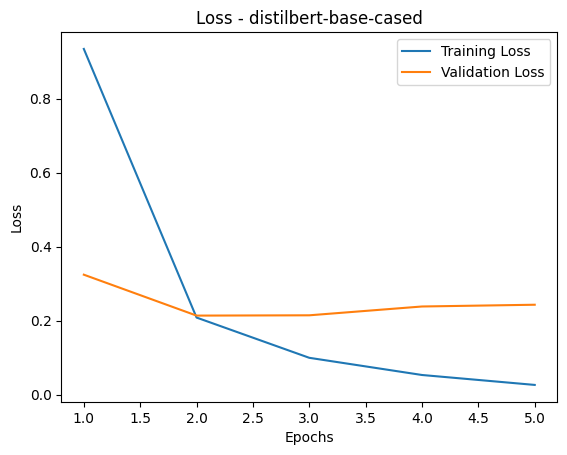

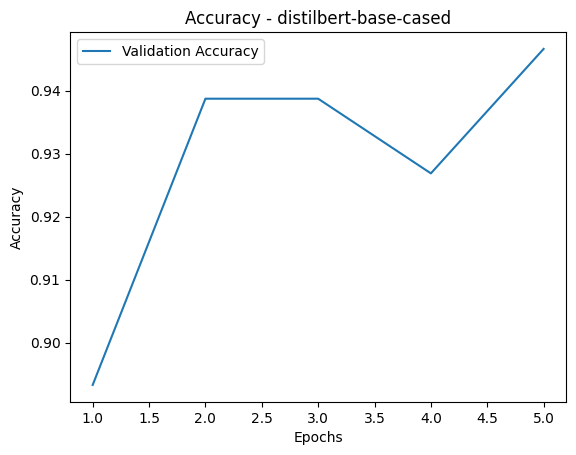


Training complete!
Total training took 0:02:26


In [ ]:
plot_training_stats(training_stats, "distilbert-base-cased", total_t0)


Next, we evaluate the model on the test set and print the accuracy score along with the test loss.

In [ ]:
best_model = torch.load(default_config["output_model_name"], weights_only=False)
best_model.to(device)

avg_test_loss, test_accuracy = evaluate(
    dataloader=test_dataloader,
    classifier=best_model,
    tokenizer=tokenizer,
    id_to_label_map=id_to_label_map,
    label_list=label_list,
    nll_loss_fn=torch.nn.CrossEntropyLoss(ignore_index=-1),
    print_classification_output=True,
    print_result_summary=True
)

print(f"\n✅ Test Accuracy: {test_accuracy:.3f}")
print(f"✅ Test Loss: {avg_test_loss:.3f}")



------------------------
  Classification outcomes
is_correct	gold_label	system_label	text
------------------------
[OK]	NUM	NUM	How far is it from Denver to Aspen?
[OK]	LOC	LOC	What county is Modesto, California in?
[OK]	HUM	HUM	Who was Galileo?
[OK]	DESC	DESC	What is an atom?
[OK]	NUM	NUM	When did Hawaii become a state?
[OK]	NUM	NUM	How tall is the Sears Building?
[OK]	HUM	HUM	George Bush purchased a small interest in which baseball team?
[OK]	ENTY	ENTY	What is Australia ' s national flower?
[OK]	DESC	DESC	Why does the moon turn orange?
[OK]	DESC	DESC	What is autism?
[OK]	LOC	LOC	What city had a world fair in 1900?
[OK]	HUM	HUM	What person ' s head is on a dime?
[OK]	NUM	NUM	What is the average weight of a Yellow Labrador?
[OK]	HUM	HUM	Who was the first man to fly across the Pacific Ocean?
[OK]	NUM	NUM	When did Idaho become a state?
[OK]	NUM	NUM	What is the life expectancy for crickets?
[OK]	ENTY	ENTY	What metal has the highest melting point?
[OK]	HUM	HUM	Who developed the vaccinati

The model achieves a high test accuracy of 97.2%, indicating that it generalizes well to unseen data.

# **Procedure 1.2**: Multiple Bert Model on Question Classification Dataset

In the second part, we explore the use of the following models: albert-base-v2, bert-base-cased, and roberta-base, to see if they produce different results.
https://huggingface.co/albert/albert-base-v2
https://huggingface.co/google-bert/bert-base-cased
https://huggingface.co/FacebookAI/roberta-base

We expect to observe variations in accuracy, training time, and model size. For example, ALBERT is designed to be more parameter-efficient and faster, but may trade off some accuracy. RoBERTa, on the other hand, is typically more robust due to its larger training corpus and optimized pretraining setup, which could lead to higher performance...

In [ ]:
model_names = [
    "albert-base-v2",
    "bert-base-cased",
    "roberta-base"
]


In [ ]:
results = []

for model_name in model_names:
    print(f"Training and evaluating {model_name}")

    #we have to change the default_config for every model
    config = default_config.copy()
    config["output_model_name"] = f"best_model_{model_name.replace('/', '_')}.pt"

#sostanzialmente ora invece che richiamare le funzioni esternamente le chiamiamo nel ciclo for
    #creating the tokenizer for every model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    config["tokenizer"] = tokenizer  # lo mettiamo in config per le funzioni che lo richiedono

    #costruzione del modello e componenti (senza tokenizer)
    classifier, optimizer, scheduler = build_model_components(
        model_name=model_name,
        num_labels=len(label_list),
        dropout_rate=config["out_dropout_rate"],
        learning_rate=config["learning_rate"],
        config=config
    )

    #preparazione dataloader
    train_dataloader = generate_data_loader(train_subset_examples, label_to_id_map, tokenizer, config["batch_size"], config["max_seq_length"], do_shuffle=True)
    dev_dataloader = generate_data_loader(dev_subset_examples, label_to_id_map, tokenizer, config["batch_size"], config["max_seq_length"], do_shuffle=False)
    test_dataloader = generate_data_loader(test_examples, label_to_id_map, tokenizer, config["batch_size"], config["max_seq_length"], do_shuffle=False)

    nll_loss_fn = torch.nn.CrossEntropyLoss(ignore_index=-1)

    #training and validation (without saving training stats)
    train_and_validate(
        classifier=classifier,
        train_dataloader=train_dataloader,
        dev_dataloader=dev_dataloader,
        optimizer=optimizer,
        scheduler=scheduler,
        nll_loss_fn=nll_loss_fn,
        config=config,
        output_model_name=config["output_model_name"]
    )

    #il modello migliore salvato verrà usato per valutare il test set
    best_model = torch.load(config["output_model_name"], weights_only=False)
    best_model.to(device)

    #valutazione su test set
    avg_test_loss, test_accuracy = evaluate(
        dataloader=test_dataloader,
        classifier=best_model,
        tokenizer=tokenizer,
        id_to_label_map=id_to_label_map,
        label_list=label_list,
        nll_loss_fn=nll_loss_fn,
        print_classification_output=False,
        print_result_summary=False
    )

    results.append({
    "model": model_name,
    "test_accuracy": test_accuracy,
    "test_loss": avg_test_loss,
    "learning_rate": config["learning_rate"],
    "dropout_rate": config["out_dropout_rate"]
})


# costruzione tabella risultati
import pandas as pd
df_results = pd.DataFrame(results)



loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--albert-base-v2/snapshots/8e2f239c5f8a2c0f253781ca60135db913e5c80c/config.json
Model config AlbertConfig {
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_memory_blocks": 0,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.51.3",
  "type_vocab_size": 2,
  "vocab_size": 30000
}

loading file spiece.model from cache at /roo

Training and evaluating albert-base-v2


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--albert-base-v2/snapshots/8e2f239c5f8a2c0f253781ca60135db913e5c80c/config.json
Model config AlbertConfig {
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_memory_blocks": 0,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.51.3",
  "type_vocab_size": 2,
  "vocab_size": 30000
}

Xet Storage is enabled for this repo, but th

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--albert-base-v2/snapshots/8e2f239c5f8a2c0f253781ca60135db913e5c80c/model.safetensors
Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertModel: ['predictions.LayerNorm.bias', 'predictions.LayerNorm.weight', 'predictions.bias', 'predictions.decoder.bias', 'predictions.dense.bias', 'predictions.dense.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of AlbertModel were initialized from the model checkpoint at albert-base-v2.
If your tas


======== Epoch 1 / 5 ========
Training...
  Batch    10  of     72.    Elapsed: 0:00:07
  Batch    20  of     72.    Elapsed: 0:00:14
  Batch    30  of     72.    Elapsed: 0:00:20
  Batch    40  of     72.    Elapsed: 0:00:27
  Batch    50  of     72.    Elapsed: 0:00:34
  Batch    60  of     72.    Elapsed: 0:00:40
  Batch    70  of     72.    Elapsed: 0:00:47

  Average training loss: 0.707
  Training epoch took: 0:00:47

Running Dev Evaluation...
  Accuracy: 0.872
  Dev Loss: 0.383
  Dev Eval took: 0:00:02

  Saving the model during epoch 1
  New Best Dev Accuracy: 0.872

======== Epoch 2 / 5 ========
Training...
  Batch    10  of     72.    Elapsed: 0:00:06
  Batch    20  of     72.    Elapsed: 0:00:13
  Batch    30  of     72.    Elapsed: 0:00:19
  Batch    40  of     72.    Elapsed: 0:00:25
  Batch    50  of     72.    Elapsed: 0:00:32
  Batch    60  of     72.    Elapsed: 0:00:38
  Batch    70  of     72.    Elapsed: 0:00:45

  Average training loss: 0.252
  Training epoch took

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.51.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}



vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/tokenizer_config.json
loading file chat_template.jinja from cache at None
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidde

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/model.safetensors
A pretrained model of type `BertModel` contains parameters that have been renamed internally (a few are listed below but more are present in the model):
* `bert.encoder.layer.9.output.LayerNorm.beta` -> `encoder.layer.9.output.LayerNorm.bias`
* `bert.encoder.layer.9.output.LayerNorm.gamma` -> `encoder.layer.9.output.LayerNorm.weight`
If you are using a model from the Hub, consider submitting a PR to adjust these weights and help future users.
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.beta', 'cls.predictions.transform.LayerNorm.gamma', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if y


======== Epoch 1 / 5 ========
Training...
  Batch    10  of     72.    Elapsed: 0:00:06
  Batch    20  of     72.    Elapsed: 0:00:12
  Batch    30  of     72.    Elapsed: 0:00:18
  Batch    40  of     72.    Elapsed: 0:00:24
  Batch    50  of     72.    Elapsed: 0:00:30
  Batch    60  of     72.    Elapsed: 0:00:36
  Batch    70  of     72.    Elapsed: 0:00:42

  Average training loss: 0.723
  Training epoch took: 0:00:43

Running Dev Evaluation...
  Accuracy: 0.923
  Dev Loss: 0.254
  Dev Eval took: 0:00:02

  Saving the model during epoch 1
  New Best Dev Accuracy: 0.923

======== Epoch 2 / 5 ========
Training...
  Batch    10  of     72.    Elapsed: 0:00:06
  Batch    20  of     72.    Elapsed: 0:00:12
  Batch    30  of     72.    Elapsed: 0:00:18
  Batch    40  of     72.    Elapsed: 0:00:24
  Batch    50  of     72.    Elapsed: 0:00:30
  Batch    60  of     72.    Elapsed: 0:00:36
  Batch    70  of     72.    Elapsed: 0:00:42

  Average training loss: 0.168
  Training epoch took

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b/config.json
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.51.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}



vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

loading file vocab.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b/vocab.json
loading file merges.txt from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b/merges.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b/tokenizer_config.json
loading file chat_template.jinja from cache at None
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b/config.json
Model config RobertaConfig {
  "architectures"

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b/model.safetensors
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.de


======== Epoch 1 / 5 ========
Training...
  Batch    10  of     72.    Elapsed: 0:00:06
  Batch    20  of     72.    Elapsed: 0:00:12
  Batch    30  of     72.    Elapsed: 0:00:18
  Batch    40  of     72.    Elapsed: 0:00:24
  Batch    50  of     72.    Elapsed: 0:00:31
  Batch    60  of     72.    Elapsed: 0:00:37
  Batch    70  of     72.    Elapsed: 0:00:43

  Average training loss: 0.911
  Training epoch took: 0:00:44

Running Dev Evaluation...
  Accuracy: 0.870
  Dev Loss: 0.367
  Dev Eval took: 0:00:01

  Saving the model during epoch 1
  New Best Dev Accuracy: 0.870

======== Epoch 2 / 5 ========
Training...
  Batch    10  of     72.    Elapsed: 0:00:06
  Batch    20  of     72.    Elapsed: 0:00:12
  Batch    30  of     72.    Elapsed: 0:00:18
  Batch    40  of     72.    Elapsed: 0:00:24
  Batch    50  of     72.    Elapsed: 0:00:30
  Batch    60  of     72.    Elapsed: 0:00:36
  Batch    70  of     72.    Elapsed: 0:00:42

  Average training loss: 0.225
  Training epoch took

             model  test_accuracy  test_loss
0   albert-base-v2          0.958   0.188557
1  bert-base-cased          0.980   0.092027
2     roberta-base          0.970   0.108979


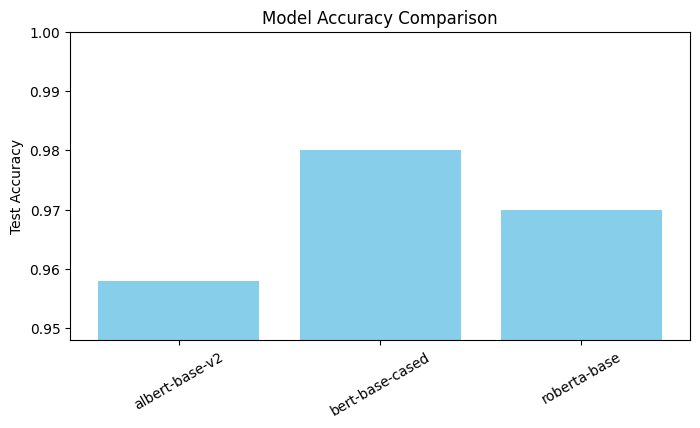

In [ ]:
print(df_results)
# Grafico a barre delle accuracy
plt.figure(figsize=(8,4))
plt.bar(df_results["model"], df_results["test_accuracy"], color='skyblue')
plt.ylabel("Test Accuracy")
plt.title("Model Accuracy Comparison")
min_acc = df_results["test_accuracy"].min()
plt.ylim(min_acc - 0.01, 1)  # parte da poco sotto il minimo, per vedere meglio le differenze
plt.xticks(rotation=30)
plt.show()

Among the tested models, BERT-base-cased achieved the highest accuracy (98.0%) and the lowest loss, showing the best overall performance. RoBERTa-base followed with 97.0%, while ALBERT-base-v2 performed the lowest at 95.8%.

Compared to DistilBERT, which previously reached 97.2%, we see that it outperforms ALBERT and comes close to RoBERTa, making it a very efficient choice with strong performance.

These results show that BERT remains the most accurate, while DistilBERT offers a good balance between accuracy and efficiency.

# **PART 2**: Text Classification on the 20 Newsgroups Dataset

In this exercise, we apply the same modular classification pipeline to the 20 Newsgroups dataset, a widely used benchmark for text classification tasks. The dataset contains news articles categorized into 20 different topics, making it a more complex, multi-class classification problem compared to the Question Classification dataset used earlier.

We aim to evaluate how well transformer-based models can distinguish between a larger number of classes and whether the differences observed in previous experiments (e.g., between BERT, RoBERTa, DistilBERT, and ALBERT) hold in a more challenging setting.

In [ ]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split

newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
df = pd.DataFrame({
    'text': newsgroups.data,
    'label': newsgroups.target
})

label_names = newsgroups.target_names
df['label_name'] = df['label'].apply(lambda x: label_names[x])

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label_name'])


train_sentences = df_train['text'].to_list()
train_labels = df_train['label_name'].to_list()



test_sentences = df_test['text'].to_list()
test_labels = df_test['label_name'].to_list()



train_examples = list(zip(train_sentences, train_labels))
test_examples = list(zip(test_sentences, test_labels))

In [ ]:
label_list = list(set(train_labels) | set(test_labels))
label_list.sort()

print("Target Labels:\t" + str(label_list))
print("Number of Labels:\t" + str(len(label_list)))

label_to_id_map, id_to_label_map = create_label_maps(label_list)

Target Labels:	['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
Number of Labels:	20


We define a default_config dictionary to store all the key hyperparameters and settings for the 20 Newsgroups classification task. Compared to the previous dataset, we adjust a few parameters to better fit the nature of longer news articles and the higher number of classes:

- Increased max_seq_length to 256 to handle longer texts.
- Reduced batch_size to 16 for memory efficiency.
- Set num_train_epochs to 3 to limit training time.

I buy also more GPU from colab...

In [ ]:
default_config = {
    "max_seq_length": 256,  # a bit longer texts for news articles
    "out_dropout_rate": 0.1,
    "dev_perc": 0.1,
    "batch_size": 16,       # reduce batch size for memory reasons
    "learning_rate": 2e-5,
    "num_train_epochs": 3,
    "output_model_name": "best_model_20newsgroups.pt",
    "apply_scheduler": False,
    "warmup_proportion": 0.1,
    "print_each_n_step": 50,
    "id_to_label_map": id_to_label_map,
    "label_list": label_list,
    }

I start with bert-base-cased, which was the best-performing model on the previous dataset.

## BERT- BASE - CASE Model with 3 Epochs

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
default_config["tokenizer"] = tokenizer

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.51.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}



vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/tokenizer_config.json
loading file chat_template.jinja from cache at None
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidde

In [ ]:
train_subset_examples, dev_subset_examples = split_train_dev(train_examples, default_config["dev_perc"])

train_dataloader = generate_data_loader(train_subset_examples, label_to_id_map, tokenizer, default_config["batch_size"], default_config["max_seq_length"], do_shuffle=True)
dev_dataloader = generate_data_loader(dev_subset_examples, label_to_id_map, tokenizer, default_config["batch_size"], default_config["max_seq_length"], do_shuffle=False)
test_dataloader = generate_data_loader(test_examples, label_to_id_map, tokenizer, default_config["batch_size"], default_config["max_seq_length"], do_shuffle=False)

default_config["num_train_examples"] = len(train_subset_examples)

I call the same functions that i used on the previous dataset

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.51.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/model.safetensors
A pretrained model of type `BertModel` contains parameters that have been renamed internally (a few are listed below but more are present in the model):
* `bert.encoder.layer.9.output.LayerNorm.beta` -> `encoder.layer.9.output.LayerNorm.bias`
* `bert.encoder.layer.9.output.LayerNorm.gamma` -> `encoder.layer.9.output.LayerNorm.weight`
If you are using a model from the Hub, consider submitting a PR to adjust these weights and help future users.
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.beta', 'cls.predictions.transform.LayerNorm.gamma', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if y


======== Epoch 1 / 3 ========
Training...
  Batch    50  of    848.    Elapsed: 0:00:09
  Batch   100  of    848.    Elapsed: 0:00:16
  Batch   150  of    848.    Elapsed: 0:00:24
  Batch   200  of    848.    Elapsed: 0:00:31
  Batch   250  of    848.    Elapsed: 0:00:39
  Batch   300  of    848.    Elapsed: 0:00:47
  Batch   350  of    848.    Elapsed: 0:00:54
  Batch   400  of    848.    Elapsed: 0:01:02
  Batch   450  of    848.    Elapsed: 0:01:09
  Batch   500  of    848.    Elapsed: 0:01:17
  Batch   550  of    848.    Elapsed: 0:01:25
  Batch   600  of    848.    Elapsed: 0:01:32
  Batch   650  of    848.    Elapsed: 0:01:40
  Batch   700  of    848.    Elapsed: 0:01:47
  Batch   750  of    848.    Elapsed: 0:01:55
  Batch   800  of    848.    Elapsed: 0:02:03

  Average training loss: 1.229
  Training epoch took: 0:02:10

Running Dev Evaluation...
  Accuracy: 0.712
  Dev Loss: 0.921
  Dev Eval took: 0:00:05

  Saving the model during epoch 1
  New Best Dev Accuracy: 0.712

===

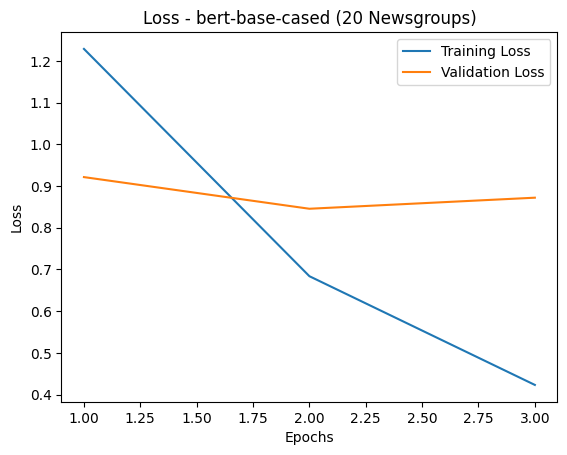

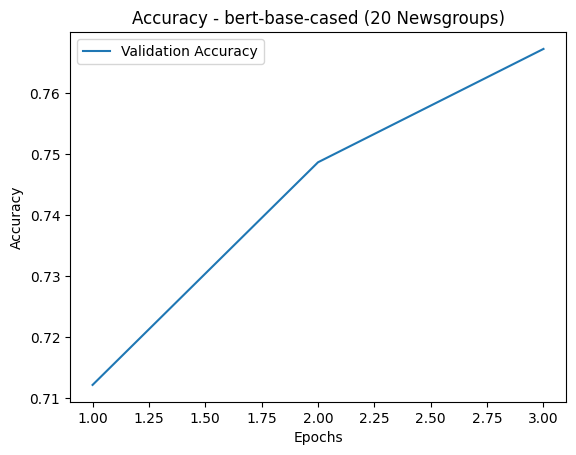


Training complete!
Total training took 0:06:44

------------------------
  Summary
------------------------
                          precision    recall  f1-score   support

             alt.atheism      0.669     0.556     0.608       160
           comp.graphics      0.754     0.723     0.738       195
 comp.os.ms-windows.misc      0.753     0.711     0.731       197
comp.sys.ibm.pc.hardware      0.680     0.704     0.692       196
   comp.sys.mac.hardware      0.812     0.715     0.760       193
          comp.windows.x      0.858     0.854     0.856       198
            misc.forsale      0.871     0.759     0.811       195
               rec.autos      0.535     0.813     0.645       198
         rec.motorcycles      0.702     0.794     0.745       199
      rec.sport.baseball      0.943     0.824     0.879       199
        rec.sport.hockey      0.909     0.895     0.902       200
               sci.crypt      0.740     0.818     0.777       198
         sci.electronics      0.

In [ ]:
classifier, optimizer, scheduler = build_model_components(
    model_name="bert-base-cased",
    num_labels=len(label_list),
    dropout_rate=default_config["out_dropout_rate"],
    learning_rate=default_config["learning_rate"],
    config=default_config
)

nll_loss_fn = torch.nn.CrossEntropyLoss(ignore_index=-1)
total_t0 = time.time()

training_stats = train_and_validate(
    classifier=classifier,
    train_dataloader=train_dataloader,
    dev_dataloader=dev_dataloader,
    optimizer=optimizer,
    scheduler=scheduler,
    nll_loss_fn=nll_loss_fn,
    config=default_config,
    output_model_name=default_config["output_model_name"]
)

plot_training_stats(training_stats, "bert-base-cased (20 Newsgroups)", total_t0)

best_model = torch.load(default_config["output_model_name"], weights_only=False)
best_model.to(device)

avg_test_loss, test_accuracy = evaluate(
    dataloader=test_dataloader,
    classifier=best_model,
    tokenizer=tokenizer,
    id_to_label_map=id_to_label_map,
    label_list=label_list,
    nll_loss_fn=nll_loss_fn,
    print_classification_output=False,
    print_result_summary=True
)

print(f"\n✅ Test Accuracy: {test_accuracy:.3f}")
print(f"✅ Test Loss: {avg_test_loss:.3f}")

## DISTILBERT-BASE-CASED  Model Trained for 3 Epochs with Hyperparameter Tuning

On the 20 Newsgroups dataset, it achieves a test accuracy of 75.0% and a test loss of 0.890.
This result reflects the increased difficulty of the task due to the larger number of classes and longer input texts, but it still shows that BERT captures relevant patterns reasonably well.

Now we change the model to distilbert-base-cased and we some hyperparameter tuning.

In this part of the experiment, we fine-tuned distilbert-base-cased by testing different combinations of learning rate, batch size, and maximum sequence length.
This tuning was only performed on the development set, not the test set, for the following reasons:

- Prevent overfitting : the test set must remain unseen during tuning to ensure that final accuracy reflects true generalization. Using the test set for hyperparameter selection would bias the evaluation.

- Model selection: The goal here is to find the best combination of hyperparameters based on validation performance (on the dev set), which will then be used to train the final model for evaluation on the test set.

In [ ]:
#num of epochs = 3
model_name = "distilbert-base-cased"

learning_rates = [1e-5, 2e-5, 3e-5]
batch_sizes = [16, 32, 64]
max_seq_lengths = [64, 128]

results = []

for lr in learning_rates:
    for bs in batch_sizes:
        for seq_len in max_seq_lengths:
            print(f"Training with lr={lr}, batch_size={bs}, max_seq_length={seq_len}")

            config = default_config.copy()
            config["learning_rate"] = lr
            config["batch_size"] = bs
            config["max_seq_length"] = seq_len
            config["output_model_name"] = f"model_lr{lr}_bs{bs}_seq{seq_len}.pt"


            tokenizer = AutoTokenizer.from_pretrained(model_name)

            # dataloader with the different max_seq_length and batch size
            train_dataloader = generate_data_loader(train_subset_examples, label_to_id_map, tokenizer, bs, seq_len, do_shuffle=True)
            dev_dataloader = generate_data_loader(dev_subset_examples, label_to_id_map, tokenizer, bs, seq_len, do_shuffle=False)


            classifier, optimizer, scheduler = build_model_components(
                model_name=model_name,
                num_labels=len(label_list),
                dropout_rate=config["out_dropout_rate"],
                learning_rate=lr,
                config=config
            )

            # Training
            train_and_validate(classifier, train_dataloader, dev_dataloader, optimizer, scheduler, torch.nn.CrossEntropyLoss(ignore_index=-1), config, config["output_model_name"])

            #best model
            best_model = torch.load(config["output_model_name"],weights_only=False)
            best_model.to(device)

            avg_loss, accuracy = evaluate(dev_dataloader, best_model, tokenizer, id_to_label_map, label_list, torch.nn.CrossEntropyLoss(ignore_index=-1))

            results.append({
                "learning_rate": lr,
                "batch_size": bs,
                "max_seq_length": seq_len,
                "accuracy": accuracy,
                "loss": avg_loss
            })


import pandas as pd
df_results = pd.DataFrame(results)
print(df_results)


Training with lr=1e-05, batch_size=16, max_seq_length=64


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed32b986cdcdcffcf0/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.51.3",
  "vocab_size": 28996
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed32b986cdcdcffcf0/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed3


======== Epoch 1 / 3 ========
Training...
  Batch    50  of    848.    Elapsed: 0:00:01
  Batch   100  of    848.    Elapsed: 0:00:02
  Batch   150  of    848.    Elapsed: 0:00:04
  Batch   200  of    848.    Elapsed: 0:00:05
  Batch   250  of    848.    Elapsed: 0:00:06
  Batch   300  of    848.    Elapsed: 0:00:07
  Batch   350  of    848.    Elapsed: 0:00:09
  Batch   400  of    848.    Elapsed: 0:00:10
  Batch   450  of    848.    Elapsed: 0:00:11
  Batch   500  of    848.    Elapsed: 0:00:12
  Batch   550  of    848.    Elapsed: 0:00:14
  Batch   600  of    848.    Elapsed: 0:00:15
  Batch   650  of    848.    Elapsed: 0:00:16
  Batch   700  of    848.    Elapsed: 0:00:17
  Batch   750  of    848.    Elapsed: 0:00:19
  Batch   800  of    848.    Elapsed: 0:00:20

  Average training loss: 1.650
  Training epoch took: 0:00:21

Running Dev Evaluation...
  Accuracy: 0.625
  Dev Loss: 1.221
  Dev Eval took: 0:00:01

  Saving the model during epoch 1
  New Best Dev Accuracy: 0.625

===

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed32b986cdcdcffcf0/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.51.3",
  "vocab_size": 28996
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed32b986cdcdcffcf0/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed3


======== Epoch 1 / 3 ========
Training...
  Batch    50  of    848.    Elapsed: 0:00:02
  Batch   100  of    848.    Elapsed: 0:00:04
  Batch   150  of    848.    Elapsed: 0:00:06
  Batch   200  of    848.    Elapsed: 0:00:08
  Batch   250  of    848.    Elapsed: 0:00:10
  Batch   300  of    848.    Elapsed: 0:00:13
  Batch   350  of    848.    Elapsed: 0:00:15
  Batch   400  of    848.    Elapsed: 0:00:17
  Batch   450  of    848.    Elapsed: 0:00:19
  Batch   500  of    848.    Elapsed: 0:00:21
  Batch   550  of    848.    Elapsed: 0:00:23
  Batch   600  of    848.    Elapsed: 0:00:25
  Batch   650  of    848.    Elapsed: 0:00:27
  Batch   700  of    848.    Elapsed: 0:00:29
  Batch   750  of    848.    Elapsed: 0:00:31
  Batch   800  of    848.    Elapsed: 0:00:33

  Average training loss: 1.510
  Training epoch took: 0:00:35

Running Dev Evaluation...
  Accuracy: 0.673
  Dev Loss: 1.073
  Dev Eval took: 0:00:01

  Saving the model during epoch 1
  New Best Dev Accuracy: 0.673

===

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed32b986cdcdcffcf0/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.51.3",
  "vocab_size": 28996
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed32b986cdcdcffcf0/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed3


======== Epoch 1 / 3 ========
Training...
  Batch    50  of    424.    Elapsed: 0:00:02
  Batch   100  of    424.    Elapsed: 0:00:04
  Batch   150  of    424.    Elapsed: 0:00:06
  Batch   200  of    424.    Elapsed: 0:00:08
  Batch   250  of    424.    Elapsed: 0:00:10
  Batch   300  of    424.    Elapsed: 0:00:12
  Batch   350  of    424.    Elapsed: 0:00:14
  Batch   400  of    424.    Elapsed: 0:00:16

  Average training loss: 1.797
  Training epoch took: 0:00:17

Running Dev Evaluation...
  Accuracy: 0.601
  Dev Loss: 1.276
  Dev Eval took: 0:00:01

  Saving the model during epoch 1
  New Best Dev Accuracy: 0.601

======== Epoch 2 / 3 ========
Training...
  Batch    50  of    424.    Elapsed: 0:00:02
  Batch   100  of    424.    Elapsed: 0:00:04
  Batch   150  of    424.    Elapsed: 0:00:06
  Batch   200  of    424.    Elapsed: 0:00:08
  Batch   250  of    424.    Elapsed: 0:00:10
  Batch   300  of    424.    Elapsed: 0:00:12
  Batch   350  of    424.    Elapsed: 0:00:14
  Batch

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed32b986cdcdcffcf0/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.51.3",
  "vocab_size": 28996
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed32b986cdcdcffcf0/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed3


======== Epoch 1 / 3 ========
Training...
  Batch    50  of    424.    Elapsed: 0:00:04
  Batch   100  of    424.    Elapsed: 0:00:08
  Batch   150  of    424.    Elapsed: 0:00:11
  Batch   200  of    424.    Elapsed: 0:00:15
  Batch   250  of    424.    Elapsed: 0:00:19
  Batch   300  of    424.    Elapsed: 0:00:23
  Batch   350  of    424.    Elapsed: 0:00:26
  Batch   400  of    424.    Elapsed: 0:00:30

  Average training loss: 1.686
  Training epoch took: 0:00:32

Running Dev Evaluation...
  Accuracy: 0.629
  Dev Loss: 1.140
  Dev Eval took: 0:00:01

  Saving the model during epoch 1
  New Best Dev Accuracy: 0.629

======== Epoch 2 / 3 ========
Training...
  Batch    50  of    424.    Elapsed: 0:00:04
  Batch   100  of    424.    Elapsed: 0:00:08
  Batch   150  of    424.    Elapsed: 0:00:11
  Batch   200  of    424.    Elapsed: 0:00:15
  Batch   250  of    424.    Elapsed: 0:00:19
  Batch   300  of    424.    Elapsed: 0:00:23
  Batch   350  of    424.    Elapsed: 0:00:26
  Batch

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed32b986cdcdcffcf0/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.51.3",
  "vocab_size": 28996
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed32b986cdcdcffcf0/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed3


======== Epoch 1 / 3 ========
Training...
  Batch    50  of    212.    Elapsed: 0:00:04
  Batch   100  of    212.    Elapsed: 0:00:07
  Batch   150  of    212.    Elapsed: 0:00:11
  Batch   200  of    212.    Elapsed: 0:00:15

  Average training loss: 2.007
  Training epoch took: 0:00:16

Running Dev Evaluation...
  Accuracy: 0.578
  Dev Loss: 1.381
  Dev Eval took: 0:00:01

  Saving the model during epoch 1
  New Best Dev Accuracy: 0.578

======== Epoch 2 / 3 ========
Training...
  Batch    50  of    212.    Elapsed: 0:00:04
  Batch   100  of    212.    Elapsed: 0:00:07
  Batch   150  of    212.    Elapsed: 0:00:11
  Batch   200  of    212.    Elapsed: 0:00:15

  Average training loss: 1.257
  Training epoch took: 0:00:16

Running Dev Evaluation...
  Accuracy: 0.621
  Dev Loss: 1.205
  Dev Eval took: 0:00:01

  Saving the model during epoch 2
  New Best Dev Accuracy: 0.621

======== Epoch 3 / 3 ========
Training...
  Batch    50  of    212.    Elapsed: 0:00:04
  Batch   100  of    21

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed32b986cdcdcffcf0/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.51.3",
  "vocab_size": 28996
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed32b986cdcdcffcf0/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed3


======== Epoch 1 / 3 ========
Training...
  Batch    50  of    212.    Elapsed: 0:00:07
  Batch   100  of    212.    Elapsed: 0:00:14
  Batch   150  of    212.    Elapsed: 0:00:21
  Batch   200  of    212.    Elapsed: 0:00:28

  Average training loss: 1.908
  Training epoch took: 0:00:30

Running Dev Evaluation...
  Accuracy: 0.605
  Dev Loss: 1.257
  Dev Eval took: 0:00:01

  Saving the model during epoch 1
  New Best Dev Accuracy: 0.605

======== Epoch 2 / 3 ========
Training...
  Batch    50  of    212.    Elapsed: 0:00:07
  Batch   100  of    212.    Elapsed: 0:00:14
  Batch   150  of    212.    Elapsed: 0:00:21
  Batch   200  of    212.    Elapsed: 0:00:28

  Average training loss: 1.125
  Training epoch took: 0:00:30

Running Dev Evaluation...
  Accuracy: 0.648
  Dev Loss: 1.093
  Dev Eval took: 0:00:01

  Saving the model during epoch 2
  New Best Dev Accuracy: 0.648

======== Epoch 3 / 3 ========
Training...
  Batch    50  of    212.    Elapsed: 0:00:07
  Batch   100  of    21

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed32b986cdcdcffcf0/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.51.3",
  "vocab_size": 28996
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed32b986cdcdcffcf0/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed3


======== Epoch 1 / 3 ========
Training...
  Batch    50  of    848.    Elapsed: 0:00:01
  Batch   100  of    848.    Elapsed: 0:00:02
  Batch   150  of    848.    Elapsed: 0:00:04
  Batch   200  of    848.    Elapsed: 0:00:05
  Batch   250  of    848.    Elapsed: 0:00:06
  Batch   300  of    848.    Elapsed: 0:00:07
  Batch   350  of    848.    Elapsed: 0:00:09
  Batch   400  of    848.    Elapsed: 0:00:10
  Batch   450  of    848.    Elapsed: 0:00:11
  Batch   500  of    848.    Elapsed: 0:00:12
  Batch   550  of    848.    Elapsed: 0:00:14
  Batch   600  of    848.    Elapsed: 0:00:15
  Batch   650  of    848.    Elapsed: 0:00:16
  Batch   700  of    848.    Elapsed: 0:00:17
  Batch   750  of    848.    Elapsed: 0:00:18
  Batch   800  of    848.    Elapsed: 0:00:20

  Average training loss: 1.516
  Training epoch took: 0:00:21

Running Dev Evaluation...
  Accuracy: 0.643
  Dev Loss: 1.167
  Dev Eval took: 0:00:01

  Saving the model during epoch 1
  New Best Dev Accuracy: 0.643

===

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed32b986cdcdcffcf0/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.51.3",
  "vocab_size": 28996
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed32b986cdcdcffcf0/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed3


======== Epoch 1 / 3 ========
Training...
  Batch    50  of    848.    Elapsed: 0:00:02
  Batch   100  of    848.    Elapsed: 0:00:04
  Batch   150  of    848.    Elapsed: 0:00:06
  Batch   200  of    848.    Elapsed: 0:00:08
  Batch   250  of    848.    Elapsed: 0:00:10
  Batch   300  of    848.    Elapsed: 0:00:12
  Batch   350  of    848.    Elapsed: 0:00:15
  Batch   400  of    848.    Elapsed: 0:00:17
  Batch   450  of    848.    Elapsed: 0:00:19
  Batch   500  of    848.    Elapsed: 0:00:21
  Batch   550  of    848.    Elapsed: 0:00:23
  Batch   600  of    848.    Elapsed: 0:00:25
  Batch   650  of    848.    Elapsed: 0:00:27
  Batch   700  of    848.    Elapsed: 0:00:29
  Batch   750  of    848.    Elapsed: 0:00:31
  Batch   800  of    848.    Elapsed: 0:00:33

  Average training loss: 1.379
  Training epoch took: 0:00:35

Running Dev Evaluation...
  Accuracy: 0.672
  Dev Loss: 1.077
  Dev Eval took: 0:00:01

  Saving the model during epoch 1
  New Best Dev Accuracy: 0.672

===

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed32b986cdcdcffcf0/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.51.3",
  "vocab_size": 28996
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed32b986cdcdcffcf0/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed3


======== Epoch 1 / 3 ========
Training...
  Batch    50  of    424.    Elapsed: 0:00:02
  Batch   100  of    424.    Elapsed: 0:00:04
  Batch   150  of    424.    Elapsed: 0:00:06
  Batch   200  of    424.    Elapsed: 0:00:08
  Batch   250  of    424.    Elapsed: 0:00:10
  Batch   300  of    424.    Elapsed: 0:00:12
  Batch   350  of    424.    Elapsed: 0:00:14
  Batch   400  of    424.    Elapsed: 0:00:16

  Average training loss: 1.584
  Training epoch took: 0:00:17

Running Dev Evaluation...
  Accuracy: 0.621
  Dev Loss: 1.218
  Dev Eval took: 0:00:01

  Saving the model during epoch 1
  New Best Dev Accuracy: 0.621

======== Epoch 2 / 3 ========
Training...
  Batch    50  of    424.    Elapsed: 0:00:02
  Batch   100  of    424.    Elapsed: 0:00:04
  Batch   150  of    424.    Elapsed: 0:00:06
  Batch   200  of    424.    Elapsed: 0:00:08
  Batch   250  of    424.    Elapsed: 0:00:10
  Batch   300  of    424.    Elapsed: 0:00:12
  Batch   350  of    424.    Elapsed: 0:00:14
  Batch

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed32b986cdcdcffcf0/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.51.3",
  "vocab_size": 28996
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed32b986cdcdcffcf0/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed3


======== Epoch 1 / 3 ========
Training...
  Batch    50  of    424.    Elapsed: 0:00:04
  Batch   100  of    424.    Elapsed: 0:00:08
  Batch   150  of    424.    Elapsed: 0:00:11
  Batch   200  of    424.    Elapsed: 0:00:15
  Batch   250  of    424.    Elapsed: 0:00:19
  Batch   300  of    424.    Elapsed: 0:00:23
  Batch   350  of    424.    Elapsed: 0:00:26
  Batch   400  of    424.    Elapsed: 0:00:30

  Average training loss: 1.470
  Training epoch took: 0:00:32

Running Dev Evaluation...
  Accuracy: 0.673
  Dev Loss: 1.046
  Dev Eval took: 0:00:01

  Saving the model during epoch 1
  New Best Dev Accuracy: 0.673

======== Epoch 2 / 3 ========
Training...
  Batch    50  of    424.    Elapsed: 0:00:04
  Batch   100  of    424.    Elapsed: 0:00:08
  Batch   150  of    424.    Elapsed: 0:00:11
  Batch   200  of    424.    Elapsed: 0:00:15
  Batch   250  of    424.    Elapsed: 0:00:19
  Batch   300  of    424.    Elapsed: 0:00:23
  Batch   350  of    424.    Elapsed: 0:00:26
  Batch

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed32b986cdcdcffcf0/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.51.3",
  "vocab_size": 28996
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed32b986cdcdcffcf0/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed3


======== Epoch 1 / 3 ========
Training...
  Batch    50  of    212.    Elapsed: 0:00:04
  Batch   100  of    212.    Elapsed: 0:00:07
  Batch   150  of    212.    Elapsed: 0:00:11
  Batch   200  of    212.    Elapsed: 0:00:15

  Average training loss: 1.758
  Training epoch took: 0:00:16

Running Dev Evaluation...
  Accuracy: 0.621
  Dev Loss: 1.223
  Dev Eval took: 0:00:01

  Saving the model during epoch 1
  New Best Dev Accuracy: 0.621

======== Epoch 2 / 3 ========
Training...
  Batch    50  of    212.    Elapsed: 0:00:04
  Batch   100  of    212.    Elapsed: 0:00:07
  Batch   150  of    212.    Elapsed: 0:00:11
  Batch   200  of    212.    Elapsed: 0:00:15

  Average training loss: 1.095
  Training epoch took: 0:00:16

Running Dev Evaluation...
  Accuracy: 0.655
  Dev Loss: 1.121
  Dev Eval took: 0:00:01

  Saving the model during epoch 2
  New Best Dev Accuracy: 0.655

======== Epoch 3 / 3 ========
Training...
  Batch    50  of    212.    Elapsed: 0:00:04
  Batch   100  of    21

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed32b986cdcdcffcf0/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.51.3",
  "vocab_size": 28996
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed32b986cdcdcffcf0/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed3


======== Epoch 1 / 3 ========
Training...
  Batch    50  of    212.    Elapsed: 0:00:07
  Batch   100  of    212.    Elapsed: 0:00:14
  Batch   150  of    212.    Elapsed: 0:00:21
  Batch   200  of    212.    Elapsed: 0:00:28

  Average training loss: 1.613
  Training epoch took: 0:00:30

Running Dev Evaluation...
  Accuracy: 0.656
  Dev Loss: 1.104
  Dev Eval took: 0:00:01

  Saving the model during epoch 1
  New Best Dev Accuracy: 0.656

======== Epoch 2 / 3 ========
Training...
  Batch    50  of    212.    Elapsed: 0:00:07
  Batch   100  of    212.    Elapsed: 0:00:14
  Batch   150  of    212.    Elapsed: 0:00:21
  Batch   200  of    212.    Elapsed: 0:00:28

  Average training loss: 0.970
  Training epoch took: 0:00:30

Running Dev Evaluation...
  Accuracy: 0.689
  Dev Loss: 1.002
  Dev Eval took: 0:00:01

  Saving the model during epoch 2
  New Best Dev Accuracy: 0.689

======== Epoch 3 / 3 ========
Training...
  Batch    50  of    212.    Elapsed: 0:00:07
  Batch   100  of    21

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed32b986cdcdcffcf0/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.51.3",
  "vocab_size": 28996
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed32b986cdcdcffcf0/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed3


======== Epoch 1 / 3 ========
Training...
  Batch    50  of    848.    Elapsed: 0:00:01
  Batch   100  of    848.    Elapsed: 0:00:02
  Batch   150  of    848.    Elapsed: 0:00:04
  Batch   200  of    848.    Elapsed: 0:00:05
  Batch   250  of    848.    Elapsed: 0:00:06
  Batch   300  of    848.    Elapsed: 0:00:07
  Batch   350  of    848.    Elapsed: 0:00:09
  Batch   400  of    848.    Elapsed: 0:00:10
  Batch   450  of    848.    Elapsed: 0:00:11
  Batch   500  of    848.    Elapsed: 0:00:12
  Batch   550  of    848.    Elapsed: 0:00:14
  Batch   600  of    848.    Elapsed: 0:00:15
  Batch   650  of    848.    Elapsed: 0:00:16
  Batch   700  of    848.    Elapsed: 0:00:17
  Batch   750  of    848.    Elapsed: 0:00:18
  Batch   800  of    848.    Elapsed: 0:00:20

  Average training loss: 1.448
  Training epoch took: 0:00:21

Running Dev Evaluation...
  Accuracy: 0.649
  Dev Loss: 1.151
  Dev Eval took: 0:00:01

  Saving the model during epoch 1
  New Best Dev Accuracy: 0.649

===

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed32b986cdcdcffcf0/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.51.3",
  "vocab_size": 28996
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed32b986cdcdcffcf0/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed3


======== Epoch 1 / 3 ========
Training...
  Batch    50  of    848.    Elapsed: 0:00:02
  Batch   100  of    848.    Elapsed: 0:00:04
  Batch   150  of    848.    Elapsed: 0:00:06
  Batch   200  of    848.    Elapsed: 0:00:08
  Batch   250  of    848.    Elapsed: 0:00:10
  Batch   300  of    848.    Elapsed: 0:00:12
  Batch   350  of    848.    Elapsed: 0:00:15
  Batch   400  of    848.    Elapsed: 0:00:17
  Batch   450  of    848.    Elapsed: 0:00:19
  Batch   500  of    848.    Elapsed: 0:00:21
  Batch   550  of    848.    Elapsed: 0:00:23
  Batch   600  of    848.    Elapsed: 0:00:25
  Batch   650  of    848.    Elapsed: 0:00:27
  Batch   700  of    848.    Elapsed: 0:00:29
  Batch   750  of    848.    Elapsed: 0:00:31
  Batch   800  of    848.    Elapsed: 0:00:33

  Average training loss: 1.333
  Training epoch took: 0:00:35

Running Dev Evaluation...
  Accuracy: 0.682
  Dev Loss: 1.008
  Dev Eval took: 0:00:01

  Saving the model during epoch 1
  New Best Dev Accuracy: 0.682

===

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed32b986cdcdcffcf0/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.51.3",
  "vocab_size": 28996
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed32b986cdcdcffcf0/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed3


======== Epoch 1 / 3 ========
Training...
  Batch    50  of    424.    Elapsed: 0:00:02
  Batch   100  of    424.    Elapsed: 0:00:04
  Batch   150  of    424.    Elapsed: 0:00:06
  Batch   200  of    424.    Elapsed: 0:00:08
  Batch   250  of    424.    Elapsed: 0:00:10
  Batch   300  of    424.    Elapsed: 0:00:12
  Batch   350  of    424.    Elapsed: 0:00:14
  Batch   400  of    424.    Elapsed: 0:00:16

  Average training loss: 1.504
  Training epoch took: 0:00:17

Running Dev Evaluation...
  Accuracy: 0.645
  Dev Loss: 1.155
  Dev Eval took: 0:00:01

  Saving the model during epoch 1
  New Best Dev Accuracy: 0.645

======== Epoch 2 / 3 ========
Training...
  Batch    50  of    424.    Elapsed: 0:00:02
  Batch   100  of    424.    Elapsed: 0:00:04
  Batch   150  of    424.    Elapsed: 0:00:06
  Batch   200  of    424.    Elapsed: 0:00:08
  Batch   250  of    424.    Elapsed: 0:00:10
  Batch   300  of    424.    Elapsed: 0:00:12
  Batch   350  of    424.    Elapsed: 0:00:14
  Batch

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed32b986cdcdcffcf0/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.51.3",
  "vocab_size": 28996
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed32b986cdcdcffcf0/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed3


======== Epoch 1 / 3 ========
Training...
  Batch    50  of    424.    Elapsed: 0:00:04
  Batch   100  of    424.    Elapsed: 0:00:08
  Batch   150  of    424.    Elapsed: 0:00:11
  Batch   200  of    424.    Elapsed: 0:00:15
  Batch   250  of    424.    Elapsed: 0:00:19
  Batch   300  of    424.    Elapsed: 0:00:23
  Batch   350  of    424.    Elapsed: 0:00:26
  Batch   400  of    424.    Elapsed: 0:00:30

  Average training loss: 1.376
  Training epoch took: 0:00:32

Running Dev Evaluation...
  Accuracy: 0.679
  Dev Loss: 1.022
  Dev Eval took: 0:00:01

  Saving the model during epoch 1
  New Best Dev Accuracy: 0.679

======== Epoch 2 / 3 ========
Training...
  Batch    50  of    424.    Elapsed: 0:00:04
  Batch   100  of    424.    Elapsed: 0:00:08
  Batch   150  of    424.    Elapsed: 0:00:11
  Batch   200  of    424.    Elapsed: 0:00:15
  Batch   250  of    424.    Elapsed: 0:00:19
  Batch   300  of    424.    Elapsed: 0:00:23
  Batch   350  of    424.    Elapsed: 0:00:26
  Batch

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed32b986cdcdcffcf0/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.51.3",
  "vocab_size": 28996
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed32b986cdcdcffcf0/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed3


======== Epoch 1 / 3 ========
Training...
  Batch    50  of    212.    Elapsed: 0:00:04
  Batch   100  of    212.    Elapsed: 0:00:07
  Batch   150  of    212.    Elapsed: 0:00:11
  Batch   200  of    212.    Elapsed: 0:00:15

  Average training loss: 1.640
  Training epoch took: 0:00:16

Running Dev Evaluation...
  Accuracy: 0.627
  Dev Loss: 1.206
  Dev Eval took: 0:00:01

  Saving the model during epoch 1
  New Best Dev Accuracy: 0.627

======== Epoch 2 / 3 ========
Training...
  Batch    50  of    212.    Elapsed: 0:00:04
  Batch   100  of    212.    Elapsed: 0:00:07
  Batch   150  of    212.    Elapsed: 0:00:11
  Batch   200  of    212.    Elapsed: 0:00:15

  Average training loss: 0.986
  Training epoch took: 0:00:16

Running Dev Evaluation...
  Accuracy: 0.674
  Dev Loss: 1.095
  Dev Eval took: 0:00:01

  Saving the model during epoch 2
  New Best Dev Accuracy: 0.674

======== Epoch 3 / 3 ========
Training...
  Batch    50  of    212.    Elapsed: 0:00:04
  Batch   100  of    21

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed32b986cdcdcffcf0/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.51.3",
  "vocab_size": 28996
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed32b986cdcdcffcf0/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed3


======== Epoch 1 / 3 ========
Training...
  Batch    50  of    212.    Elapsed: 0:00:07
  Batch   100  of    212.    Elapsed: 0:00:14
  Batch   150  of    212.    Elapsed: 0:00:21
  Batch   200  of    212.    Elapsed: 0:00:28

  Average training loss: 1.482
  Training epoch took: 0:00:30

Running Dev Evaluation...
  Accuracy: 0.658
  Dev Loss: 1.060
  Dev Eval took: 0:00:01

  Saving the model during epoch 1
  New Best Dev Accuracy: 0.658

======== Epoch 2 / 3 ========
Training...
  Batch    50  of    212.    Elapsed: 0:00:07
  Batch   100  of    212.    Elapsed: 0:00:14
  Batch   150  of    212.    Elapsed: 0:00:21
  Batch   200  of    212.    Elapsed: 0:00:28

  Average training loss: 0.865
  Training epoch took: 0:00:30

Running Dev Evaluation...
  Accuracy: 0.705
  Dev Loss: 0.945
  Dev Eval took: 0:00:01

  Saving the model during epoch 2
  New Best Dev Accuracy: 0.705

======== Epoch 3 / 3 ========
Training...
  Batch    50  of    212.    Elapsed: 0:00:07
  Batch   100  of    21

**Important Note**

In this experiment, hyperparameter tuning was done manually by looping over combinations of learning rate, batch size, and maximum sequence length.
However, this process could also be automated using techniques such as grid search (systematically trying all combinations) or random search (sampling a subset of combinations).

In [ ]:
#visualizza i risultati del fine tuning
import pandas as pd
df_results = pd.DataFrame(results)
print(df_results)

    learning_rate  batch_size  max_seq_length  accuracy      loss
0         0.00001          16              64  0.671751  1.073024
1         0.00001          16             128  0.712865  0.943229
2         0.00001          32              64  0.673077  1.107447
3         0.00001          32             128  0.689655  0.991567
4         0.00001          64              64  0.651194  1.141116
5         0.00001          64             128  0.689655  1.006132
6         0.00002          16              64  0.673740  1.118513
7         0.00002          16             128  0.720159  0.967665
8         0.00002          32              64  0.688329  1.078789
9         0.00002          32             128  0.708886  0.942213
10        0.00002          64              64  0.681034  1.073939
11        0.00002          64             128  0.702255  0.954704
12        0.00003          16              64  0.686340  1.124374
13        0.00003          16             128  0.725464  0.984721
14        

Questo è il fine-tuning sul dev_set troviamo la miglior combinazione poi ora la applichiamo al test set.

In [ ]:
#trova la riga con la miglior accuracy nel dataframe dei risultati
best_idx = df_results["accuracy"].idxmax()
best_params = df_results.loc[best_idx]

best_lr = best_params["learning_rate"]
best_bs = best_params["batch_size"]
best_seq_len = best_params["max_seq_length"]

#stampa i migliori parametri trovati dal fine-tuning
print(f"Best params found: lr={best_lr}, batch_size={best_bs}, max_seq_length={best_seq_len}")

#When trying to automatically construct the filename of the best model based on the best hyperparameters stored in the pandas DataFrame (df_results),
#I encountered an issue due to type incompatibilities (e.g., mixing floats and integers when formatting the filename string).
#This happened because values like learning rates (1e-5) and batch sizes (16)
#may be stored as different types (e.g., float64, int64) in the DataFrame,
#which can lead to subtle errors when used in string formatting.

best_model_filename = f"model_lr{best_lr}_bs{int(best_bs)}_seq{int(best_seq_len)}.pt"
print(f"load best model from: {best_model_filename}")


# Ricrea tokenizer con la sequenza di lunghezza ottimale
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Crea test dataloader con batch size e max_seq_length ottimali
test_dataloader = generate_data_loader(
    test_examples,
    label_to_id_map,
    tokenizer,
    int(best_bs),
    int(best_seq_len),
    do_shuffle=False
)

# We don't need to rebuild the classifier from scratch with best params just to load the saved model.
# The saved model already contains the trained weights and the structure from the best run.

# Carica i pesi salvati del miglior modello using the correct filename, wieghts only = false ci evita
# alcuni problemi con la classe di pytorch che per motivi di sicurezza non fa accedere
best_model = torch.load(best_model_filename, weights_only=False)
best_model.to(device)

# Valuta il modello sul test set
avg_test_loss, test_accuracy = evaluate(
    dataloader=test_dataloader,
    classifier=best_model,
    tokenizer=tokenizer,
    id_to_label_map=id_to_label_map,
    label_list=label_list,
    nll_loss_fn=torch.nn.CrossEntropyLoss(ignore_index=-1),
    print_classification_output=True,
    print_result_summary=True
)

Best params found: lr=3e-05, batch_size=16.0, max_seq_length=128.0
Attempting to load best model from: model_lr3e-05_bs16_seq128.pt


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed32b986cdcdcffcf0/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.51.3",
  "vocab_size": 28996
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed32b986cdcdcffcf0/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/6ea81172465e8b0ad3fddeed3


------------------------
  Classification outcomes
is_correct	gold_label	system_label	text
------------------------
[NO]	comp.graphics	comp.sys.ibm.pc.hardware	Can You report CRT and other register state in this mode? Thank ' s.
[OK]	talk.religion.misc	talk.religion.misc	Just to remark that I have heard that David Koresh has risen from the dead. I dont know if it is true or not, but this is what I have been told. What do you guys think?
[OK]	comp.windows.x	comp.windows.x	I ' ve spent the past week tearing my hair out, trying to get the output of a piped " tail - f " to end up in a widget. I ' ve managed to make it work in some ugly ways, but either a ) X blocks on the tail and won ' t allow user input, b ) the " tail - f " functions like just " tail " and doesn ' t follow the expansion of the file, c ) the " tail - f " doesn ' t die after I ' ve closed the pipe and destoryed the widget, or d ) pclose ( )
[OK]	rec.autos	rec.autos	I ' ve had a Valentine for about 9 months now and I agre

In [ ]:
print(f"\n✅ Final Test Accuracy: {test_accuracy:.3f}")
print(f"✅ Final Test Loss: {avg_test_loss:.3f}")


✅ Final Test Accuracy: 0.714
✅ Final Test Loss: 1.010


Best params found: lr=3e-05, batch_size=16.0, max_seq_length=128.0

The best DistilBERT configuration (learning rate = 3e-5, batch size = 16, max sequence length = 128) achieves a final test accuracy of 71.4% and a test loss of 1.010 on the 20 Newsgroups dataset.

This performance is noticeably lower than the ~97% accuracy seen on the Question Classification dataset, which reflects the increased difficulty of this task: more classes, more variability in the input texts, and longer documents.
Nonetheless, achieving over 70% accuracy with a lightweight model like DistilBERT is a solid result, especially considering the reduced training time and resource requirements.

This result is lower than the 75.0% accuracy achieved by bert-base-cased without any hyperparameter tuning, confirming that the larger model still holds an advantage in more complex tasks.

## BERT - BASE - CASED Model with 5 Epochs

To obtain the best result, we increase the number of training epochs to 5 and retrain the bert-base-cased model. After training, we evaluate its performance on the test set.

In [ ]:
default_config = {
    "max_seq_length": 256,  # a bit longer texts for news articles
    "out_dropout_rate": 0.1,
    "dev_perc": 0.1,
    "batch_size": 16,       # reduce batch size for memory reasons
    "learning_rate": 2e-5,
    "num_train_epochs": 5, #we change only this one
    "output_model_name": "best_model_20newsgroups.pt",
    "apply_scheduler": False,
    "warmup_proportion": 0.1,
    "print_each_n_step": 50,
    "id_to_label_map": id_to_label_map,
    "label_list": label_list,
    }

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
default_config["tokenizer"] = tokenizer

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.51.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/vocab.txt
loading file tokenizer.json from cache at /root/.cache/hugg

In [ ]:
train_subset_examples, dev_subset_examples = split_train_dev(train_examples, default_config["dev_perc"])

train_dataloader = generate_data_loader(train_subset_examples, label_to_id_map, tokenizer, default_config["batch_size"], default_config["max_seq_length"], do_shuffle=True)
dev_dataloader = generate_data_loader(dev_subset_examples, label_to_id_map, tokenizer, default_config["batch_size"], default_config["max_seq_length"], do_shuffle=False)
test_dataloader = generate_data_loader(test_examples, label_to_id_map, tokenizer, default_config["batch_size"], default_config["max_seq_length"], do_shuffle=False)

default_config["num_train_examples"] = len(train_subset_examples)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.51.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e/model.safetensors
Some weights of the model checkpoin


======== Epoch 1 / 5 ========
Training...
  Batch    50  of    848.    Elapsed: 0:00:08
  Batch   100  of    848.    Elapsed: 0:00:15
  Batch   150  of    848.    Elapsed: 0:00:23
  Batch   200  of    848.    Elapsed: 0:00:30
  Batch   250  of    848.    Elapsed: 0:00:38
  Batch   300  of    848.    Elapsed: 0:00:46
  Batch   350  of    848.    Elapsed: 0:00:53
  Batch   400  of    848.    Elapsed: 0:01:01
  Batch   450  of    848.    Elapsed: 0:01:08
  Batch   500  of    848.    Elapsed: 0:01:16
  Batch   550  of    848.    Elapsed: 0:01:24
  Batch   600  of    848.    Elapsed: 0:01:31
  Batch   650  of    848.    Elapsed: 0:01:39
  Batch   700  of    848.    Elapsed: 0:01:46
  Batch   750  of    848.    Elapsed: 0:01:54
  Batch   800  of    848.    Elapsed: 0:02:02

  Average training loss: 1.230
  Training epoch took: 0:02:09

Running Dev Evaluation...
  Accuracy: 0.710
  Dev Loss: 0.934
  Dev Eval took: 0:00:05

  Saving the model during epoch 1
  New Best Dev Accuracy: 0.710

===

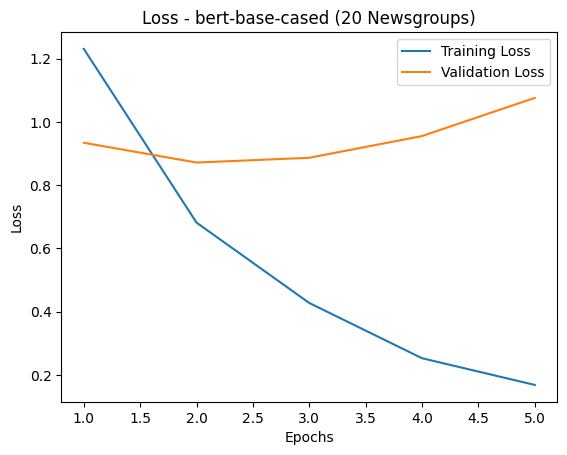

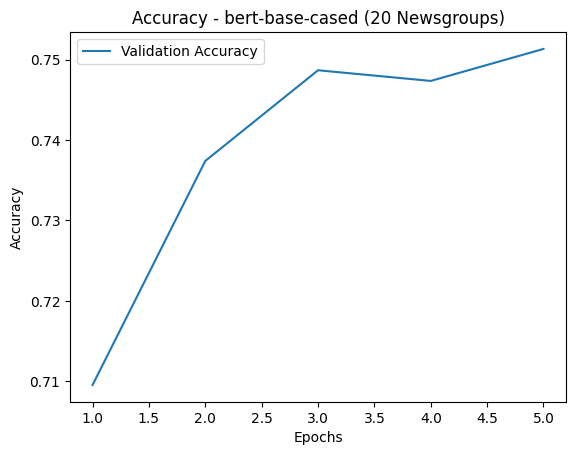


Training complete!
Total training took 0:11:11

------------------------
  Summary
------------------------
                          precision    recall  f1-score   support

             alt.atheism      0.615     0.519     0.563       160
           comp.graphics      0.868     0.574     0.691       195
 comp.os.ms-windows.misc      0.477     0.726     0.575       197
comp.sys.ibm.pc.hardware      0.649     0.668     0.658       196
   comp.sys.mac.hardware      0.767     0.751     0.759       193
          comp.windows.x      0.780     0.929     0.848       198
            misc.forsale      0.893     0.769     0.826       195
               rec.autos      0.809     0.747     0.777       198
         rec.motorcycles      0.851     0.744     0.794       199
      rec.sport.baseball      0.913     0.839     0.874       199
        rec.sport.hockey      0.888     0.910     0.899       200
               sci.crypt      0.816     0.828     0.822       198
         sci.electronics      0.

In [ ]:
classifier, optimizer, scheduler = build_model_components(
    model_name="bert-base-cased",
    num_labels=len(label_list),
    dropout_rate=default_config["out_dropout_rate"],
    learning_rate=default_config["learning_rate"],
    config=default_config
)

nll_loss_fn = torch.nn.CrossEntropyLoss(ignore_index=-1)
total_t0 = time.time()

training_stats = train_and_validate(
    classifier=classifier,
    train_dataloader=train_dataloader,
    dev_dataloader=dev_dataloader,
    optimizer=optimizer,
    scheduler=scheduler,
    nll_loss_fn=nll_loss_fn,
    config=default_config,
    output_model_name=default_config["output_model_name"]
)

plot_training_stats(training_stats, "bert-base-cased (20 Newsgroups)", total_t0)

best_model = torch.load(default_config["output_model_name"], weights_only=False)
best_model.to(device)

avg_test_loss, test_accuracy = evaluate(
    dataloader=test_dataloader,
    classifier=best_model,
    tokenizer=tokenizer,
    id_to_label_map=id_to_label_map,
    label_list=label_list,
    nll_loss_fn=nll_loss_fn,
    print_classification_output=False,
    print_result_summary=True
)

print(f"\n✅ Test Accuracy: {test_accuracy:.3f}")
print(f"✅ Test Loss: {avg_test_loss:.3f}")

In [ ]:
print(f"\n✅ Test Accuracy: {test_accuracy:.3f}")
print(f"✅ Test Loss: {avg_test_loss:.3f}")


✅ Test Accuracy: 0.754
✅ Test Loss: 1.072


After increasing the number of training epochs to 5, the bert-base-cased model achieved a test accuracy of 75.4% and a test loss of 1.072 on the 20 Newsgroups dataset.

This result shows a slight improvement over the previous 3-epoch training (75.0% accuracy), suggesting that a longer fine-tuning phase helped the model capture more complex patterns. However, the gain is modest and the loss remains relatively high

# ROBERTA LARGE model



In [ ]:
from transformers import AutoTokenizer
import torch


model_name = "roberta-large"

#adjust config for large model
default_config = {
    "max_seq_length": 256,
    "out_dropout_rate": 0.1,
    "dev_perc": 0.1,
    "batch_size": 8,  # smaller batch for memory reasons
    "learning_rate": 2e-5,
    "num_train_epochs": 3,
    "output_model_name": "best_roberta_large.pt",
    "apply_scheduler": False,
    "warmup_proportion": 0.1,
    "print_each_n_step": 50,
    "id_to_label_map": id_to_label_map,
    "label_list": label_list,
}

#initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
default_config["tokenizer"] = tokenizer

#data loaders
train_subset_examples, dev_subset_examples = split_train_dev(train_examples, default_config["dev_perc"])
train_dataloader = generate_data_loader(train_subset_examples, label_to_id_map, tokenizer, default_config["batch_size"], default_config["max_seq_length"], do_shuffle=True)
dev_dataloader = generate_data_loader(dev_subset_examples, label_to_id_map, tokenizer, default_config["batch_size"], default_config["max_seq_length"], do_shuffle=False)

#model components
classifier, optimizer, scheduler = build_model_components(
    model_name=model_name,
    num_labels=len(label_list),
    dropout_rate=default_config["out_dropout_rate"],
    learning_rate=default_config["learning_rate"],
    config=default_config
)

#train and validate
train_and_validate(
    classifier=classifier,
    train_dataloader=train_dataloader,
    dev_dataloader=dev_dataloader,
    optimizer=optimizer,
    scheduler=scheduler,
    nll_loss_fn=torch.nn.CrossEntropyLoss(ignore_index=-1),
    config=default_config,
    output_model_name=default_config["output_model_name"]
)

#evaluate on test set
best_model = torch.load(default_config["output_model_name"], weights_only=False)
best_model.to(device)

test_dataloader = generate_data_loader(test_examples, label_to_id_map, tokenizer, default_config["batch_size"], default_config["max_seq_length"], do_shuffle=False)

test_loss, test_accuracy = evaluate(
    dataloader=test_dataloader,
    classifier=best_model,
    tokenizer=tokenizer,
    id_to_label_map=id_to_label_map,
    label_list=label_list,
    nll_loss_fn=torch.nn.CrossEntropyLoss(ignore_index=-1),
    print_result_summary=True
)

print(f"\n✅ Roberta-Large Test Accuracy: {test_accuracy:.3f}")
print(f"✅ Test Loss: {test_loss:.3f}")


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-large/snapshots/722cf37b1afa9454edce342e7895e588b6ff1d59/config.json
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.51.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading file vocab.json from cache at /root/.cache/huggingface/hub/models--roberta-large/snapshots/722cf37b1afa9454edce342e7895e588b6ff1d59/vocab.json
loading file merges.txt from cache at /root/


======== Epoch 1 / 3 ========
Training...
  Batch    50  of   1696.    Elapsed: 0:00:14
  Batch   100  of   1696.    Elapsed: 0:00:27
  Batch   150  of   1696.    Elapsed: 0:00:41
  Batch   200  of   1696.    Elapsed: 0:00:54
  Batch   250  of   1696.    Elapsed: 0:01:07
  Batch   300  of   1696.    Elapsed: 0:01:20
  Batch   350  of   1696.    Elapsed: 0:01:34
  Batch   400  of   1696.    Elapsed: 0:01:47
  Batch   450  of   1696.    Elapsed: 0:02:00
  Batch   500  of   1696.    Elapsed: 0:02:14
  Batch   550  of   1696.    Elapsed: 0:02:27
  Batch   600  of   1696.    Elapsed: 0:02:40
  Batch   650  of   1696.    Elapsed: 0:02:53
  Batch   700  of   1696.    Elapsed: 0:03:07
  Batch   750  of   1696.    Elapsed: 0:03:20
  Batch   800  of   1696.    Elapsed: 0:03:33
  Batch   850  of   1696.    Elapsed: 0:03:46
  Batch   900  of   1696.    Elapsed: 0:04:00
  Batch   950  of   1696.    Elapsed: 0:04:13
  Batch  1000  of   1696.    Elapsed: 0:04:26
  Batch  1050  of   1696.    Elapsed:

Without any hyperparameter tuning, RoBERTa-Large achieved a test accuracy of 76.6% and a test loss of 0.834 on the 20 Newsgroups dataset.
This is the best result obtained so far in our experiments, outperforming all other models including bert-base-cased trained for 5 epochs (75.4%).

This confirms that larger pretrained models like RoBERTa-Large can yield stronger performance even with default training settings, thanks to their deeper architecture and more robust pretraining.
With further tuning (e.g., learning rate scheduling, early stopping, or task-specific preprocessing), it is likely that even higher accuracy could be reached.

# CONCLUSION

In this project, we applied several transformer-based models—such as bert-base-cased, distilbert-base-cased, albert-base-v2, and roberta-large—to the 20 Newsgroups text classification task. We built a modular pipeline that allowed us to train, validate, and evaluate models, as well as perform manual hyperparameter tuning.

The best result was achieved with the roberta-large model, trained with default settings (no tuning), reaching a test accuracy of 76.6% and a test loss of 0.834. This outperformed the bert-base-cased model trained for 5 epochs (75.4%), demonstrating the advantage of larger, more robust pretrained architectures—even without optimization.

While this is a strong result, it still remains below the state-of-the-art reported in the literature. In academic studies, accuracies above 85% have been achieved by combining pretrained transformers with advanced techniques, such as:

- Domain-specific fine-tuning
- Ensemble methods
- Data cleaning and augmentation
- Extended training with learning rate scheduling and early stopping

For example, some approaches using RoBERTa or fine-tuned BERT models with preprocessing pipelines have reported results between 85–88% on the 20 Newsgroups dataset.

https://arxiv.org/pdf/2105.05727v4
